In [94]:
using Distributions, PyPlot, LaTeXStrings
plt.style[:use]("/home/mcocci/Documents/ConfigurationTemplates/mystyle.mplstyle");

# Regression Reporting
function reg(Y,X)
    beta = (X'*X)\X'*Y;
    pred = X*beta;
    s_Er = std(pred);
    s_r  = std(Y);
    r2   = var(pred)/var(Y)

    println("beta = $beta")
    println("s_Er = $s_Er")
    println("s_r = $s_r")
    println("r2 = $r2")
    
    return beta
end

reg (generic function with 1 method)

## Model

Let $r_t$ and $x_t$ denote returns and (latent) expected returns in time $t$ evolving as follows:

$$
\begin{align*}
x_t &= \phi x_{t-1} + \varepsilon_t\\
r_{t+1} &= x_t + \delta_{t+1}
\end{align*}
$$

Now suppose we were to run the following regression

$$
  r_{t+1} = a + bx_t + e_t
$$

we would expect the following values
$$
\begin{align*}
b &= \frac{\text{Cov}(r_{t+1}, x_t)}{\text{Var}(x_t)} = \frac{\text{Var}(X_t) + \text{Cov}(x_t, \delta_{t+1})}{\text{Var}(x_t)}= 1 \\
\text{Var}(a+bx_t) &= b^2 \text{Var}(x_t) = \frac{\sigma^2_\varepsilon}{1-\phi^2}\\
\text{Var}(r_t) &= \text{Var}(x_{t-1} + \delta_t) = \frac{\sigma^2_\varepsilon}{1-\phi^2} + \sigma^2_\delta\\
R^2 &= 
\end{align*}
$$

In [24]:
# Compute some things
σ_ɛ = 0.018;
ϕ   = 0.94;
σ_δ = 0.18;
σ_Er = σ_ɛ/sqrt(1-ϕ^2);
σ_r  = sqrt(σ_Er^2 + σ_δ^2);
R2   = (σ_Er^2)/(σ_r^2)
println("σ_Er = $σ_Er")
println("σ_r = $σ_r")
println("R2 = $R2")

σ_Er = 0.0527589343584494
σ_r = 0.18757266633131592
R2 = 0.07911392405063285


In [114]:
# Define function to simulate from model
function Simulate(T::Int64)
  σ_ɛ = 0.018;
  ϕ   = 0.94;
  σ_δ = 0.18;
  ρ   = -0.80756;

  function DrawShocks(N::Int64)
    A = [σ_ɛ     0; 
         ρ*σ_δ   σ_δ*sqrt(1-ρ^2)]
    return A*rand(MvNormal(eye(2)),N)
  end

  x = Array(Float64, T+1);
  r = Array(Float64, T+1);

  # Initial value for xₜ
  x[1] = rand(Normal(0, σ_ɛ/(1-ϕ^2)));

  for t = 1:T
    ɛ, δ = DrawShocks(1);
    x[t+1] = ϕ*x[t] + ɛ;
    r[t+1] = x[t]   + δ;
  end

  return x,r
end

Simulate (generic function with 1 method)

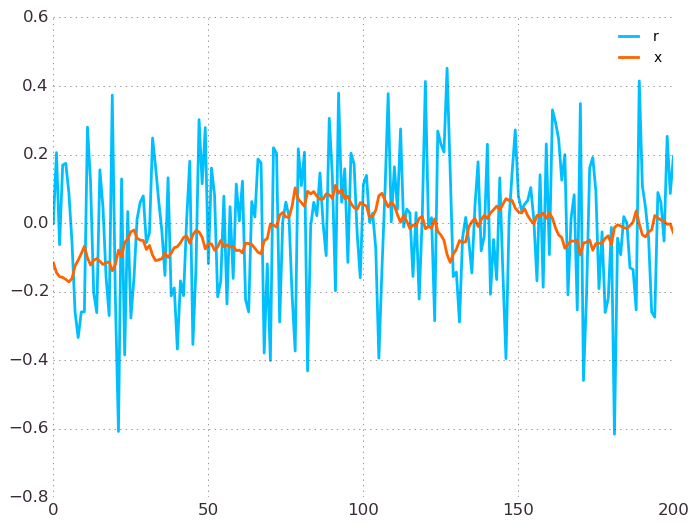

In [21]:
# Simulate and Plot
x,r = Simulate(200);
plot(r); plot(x);
legend(("r", "x"));

In [88]:
# Simulate and run regression
x,r = Simulate(100000);

Y = r[2:end];
X = [ones(length(x)-1) x[1:end-1]];
beta = reg(Y,X)

println("\nσ_Er = $σ_Er")
println("σ_r = $σ_r")
println("r2 = $r2")

beta = [0.0003710970581479944,0.9937143454553065]
s_Er = 0.05303484240848203
s_r = 0.18744148224793292
r2 = 0.08005549469874358

σ_Er = 0.0527589343584494
σ_r = 0.18757266633131592
r2 = 0.07944754478127895


Next, we run the regression

$$
  \sum^5_{i=1} r_{t+i} = a_5 + b_5 x_t + e^{(5)}_{t+5} 
$$

for which we would expect the coefficient

$$
\begin{align*}
  b_5 &= \frac{\text{Cov}\left(\sum^5_{i=1} r_{t+i}, x_t\right)}{\text{Var}(x_t)} 
  = \frac{1}{\text{Var}(x_t)}\sum^5_{i=1}\text{Cov}\left( r_{t+i}, x_t\right) \\
  &= \frac{1}{\text{Var}(x_t)}\sum^5_{i=1}\text{Cov}\left( x_{t-1+i}+\delta_{t+i}, x_t\right) \\
  &= \frac{1}{\text{Var}(x_t)}\sum^5_{i=1}\text{Cov}\left( x_{t-1+i}, x_t\right) \\
  &= \frac{1}{\text{Var}(x_t)}\sum^5_{i=1}\phi^{i-1} \text{Var}(x_t) \\
  &= \sum^5_{i=1}\phi^{i-1} = \frac{1-\phi^5}{1-\phi}
\end{align*}
$$

where we used the fact that $\text{Cov}(x_{t+i}, x_t)$ is simply the regression coefficient of $x_{t+i}$ on $x_t$, muliplied through by the variance of the regression $x_t$.

b5 = 4.43493296
beta = [0.0013469423323130166,4.404791038787379]
s_Er = 0.23186988226409253
s_r = 0.41862208804255013
r2 = 0.30679226363170153


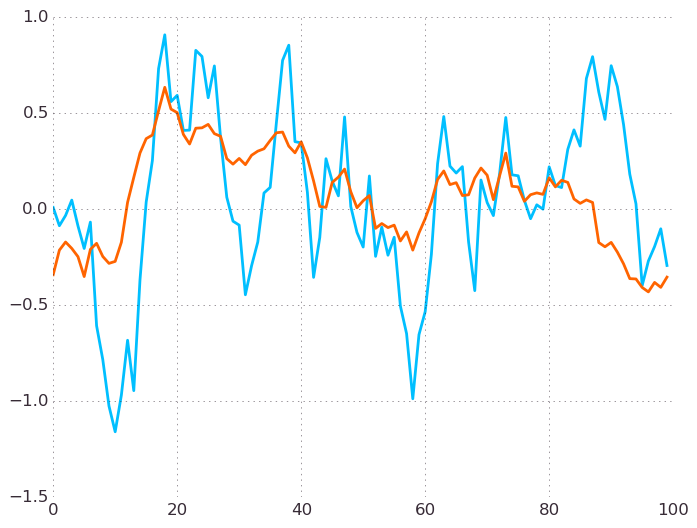

In [91]:
# Calculate b_t
b5 = (1-ϕ^5)/(1-ϕ);
println("b5 = $b5")

# Simulate and run regression
x,r = Simulate(100000);

r5 = Array(Float64, length(r)-1-4)
for t = 1:length(r5)
    r5[t] = sum(r[t+1:t+5]);
end
Y = r5;
X = [ones(length(Y)) x[1:length(r5)]];
beta = reg(Y,X);

plot(r5[1:100]); plot(X[1:100,:]*beta);

Now let's thing about a regression of returns on past returns:

$$
  r_{t+1} = a + b r_t + v_{t+1}
$$

which has regression coefficient

$$
\begin{align*}
b &= \frac{\text{Cov}(r_{t+1},r_t)}{\text{Var}(r_t)} \\
&= \frac{1}{\text{Var}(r_t)}\text{Cov}(x_t + \delta_{t+1}, x_{t-1} + \delta_t) \\
&= \frac{1}{\text{Var}(r_t)}\left(\text{Cov}(x_t, x_{t-1}) + \text{Cov}(x_t, \delta_t) + \text{Cov}(\delta_{t+1}, x_{t-1}) + \text{Cov}(\delta_{t+1}, \delta_t)\right) \\
&= \frac{1}{\text{Var}(r_t)}\left(\text{Cov}(x_t, x_{t-1}) + \text{Cov}(x_t, \delta_t) \right) \\
&= \frac{1}{\text{Var}(r_t)}\left(\phi\text{Var}(x_t) + \text{Cov}(\phi x_{t-1}+\varepsilon_t, \delta_t) \right) \\
&= \frac{1}{\text{Var}(r_t)}\left(\phi\text{Var}(x_t) + \text{Cov}(\varepsilon_t, \delta_t) \right) \\
&= \frac{1}{\text{Var}(r_t)}\left(\phi\text{Var}(x_t) + \rho \sigma_\varepsilon \sigma_\delta \right) \\
&= \frac{\phi\text{Var}(x_t) + \rho \sigma_\varepsilon \sigma_\delta}{\text{Var}(x_t)+\sigma^2_\delta} \\
\end{align*}
$$

In [134]:
# See if we can predict returns from past returns
x,r = Simulate(100000);
Y = r[3:end];
X = [ones(length(Y)) r[2:end-1]];
reg(Y,X)
σ_ɛ = 0.018;
ϕ   = 0.94;
σ_δ = 0.18;
ρ   = -0.80756;
VarX = (σ_ɛ^2)/(1-(ϕ^2));
b = (ϕ*VarX + ρ*σ_ɛ*σ_δ)/(VarX + σ_δ^2);
print(b)

beta = [-0.0004391423465508776,-0.0031940415563213105]
s_Er = 0.0005981955084405734
s_r = 0.18728220761957923
r2 = 1.0202186433954339e-5
1.2658227794979988e-8